In [1]:
import numpy as np
import numpy.random
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import random

In [2]:
def func2matidx(func, xrange, yrange, dx=0.05):
    '''Get indicies of a matrix that represent the output of a function plotted on that matrix'''
    xs = np.arange(0, xrange - 1, dx) # construct domain
    ys = func(xs) # evaluate function on domain
    
    # Clip to codomain
    xs = xs[np.logical_and(ys < yrange, ys >= 0).nonzero()].astype(int)
    ys = ys[np.logical_and(ys < yrange, ys >= 0).nonzero()].astype(int)
    
    return [xs, ys]

def tbline(theta, b):
    '''Return a function for a line parametrized by theta and its y-intercept (b)'''
    return lambda x: np.tan(theta) * x - b

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 40
            else:
                output[i][j] = image[i][j]
    return output

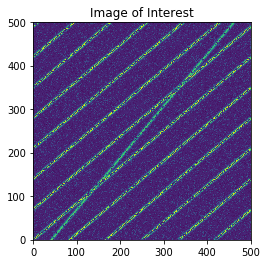

In [4]:
CARRIER_THETA = np.radians(40)
CARRIER_F0 = 0
CARRIER_SEP = 70

TARGET_THETA = np.radians(50)
TARGET_F0 = 50

img = np.zeros((500, 500))

# Add carriers
for i in np.arange(-100, 100, 1):
    [_xs, _ys] = func2matidx(tbline(CARRIER_THETA, CARRIER_F0 + CARRIER_SEP * i), img.shape[1], img.shape[0], dx=0.005)
    img[_ys, _xs] += 1000

# Add target
[_xs, _ys] = func2matidx(tbline(TARGET_THETA, TARGET_F0), img.shape[1], img.shape[0], dx=0.005)
img[_ys, _xs] += 700

# # Blur to remove "gaps" in nearly-vertical carrier lines
img = gaussian_filter(img, sigma=2)

# Add noise
img = sp_noise(img, 0.1)
img = img.astype(np.float32) + np.random.normal(10, 6, img.shape)
plt.imshow(img, origin='lower')
plt.title('Image of Interest')
plt.show()

(729, 1373)

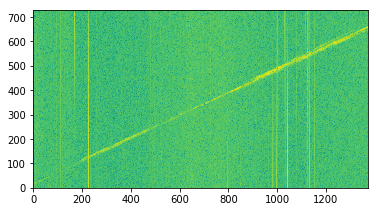

In [3]:
from PIL import Image, ImageFilter, ImageOps

img = Image.open('iono.png').convert('L')#.filter(ImageFilter.GaussianBlur(5))
img = np.flip(np.asarray(img), 1) # we're only using masks where theta between 0 and 90, so flip to get "positive slope" chirp
plt.imshow(img, origin='lower')
img.shape

## Pooling Step

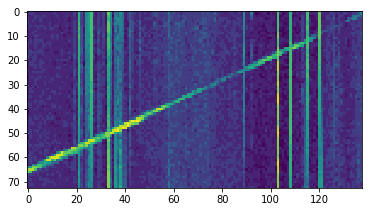

In [8]:
import skimage.measure

pool_img = np.flip(skimage.measure.block_reduce(img, (10,10), np.max), axis=1)
plt.imshow(pool_img)

img = pool_img

Progress: 10% - 20% - 30% - 40% - 50% - 60% - 70% - 80% - 90% - 100% - 

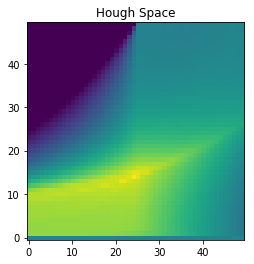

In [4]:
NTHETA = 50
NB = 50

houghm = np.zeros((NTHETA, NB))

M, N = img.shape
X,Y = np.ix_(np.arange(M), np.arange(N))
SIGMA = 5

print('Progress: ', end='')
tidx = 0
for theta in np.linspace(0, np.pi / 2, NTHETA):
    ridx = 0
    for b in np.linspace(-img.shape[0], img.shape[0], NB):
        dists = np.exp(-np.square(X * np.sin(np.pi / 2 - theta) - (Y - b) * np.cos(np.pi / 2 - theta)) / 2 / np.square(SIGMA))
        houghm[tidx, ridx] = np.sum(img * dists)
        ridx += 1
    tidx += 1
    prep = int(tidx/NTHETA*100)
    if prep % 5 == 0:
        print(f'{prep}% - ', end='')

plt.imshow(houghm, origin='lower')
plt.title('Hough Space')
plt.show()

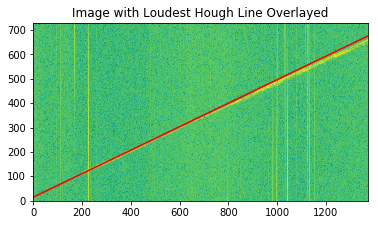

In [8]:
[tlr, blr] = np.unravel_index(np.argmax(houghm), houghm.shape)

tl = np.linspace(0, np.pi / 2, NTHETA)[tlr]
bl = np.linspace(-img.shape[0], img.shape[0], NB)[blr]

xl = np.arange(0, img.shape[1], 1)
func = tbline(tl, bl)
yl = func(xl)

xl = xl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)
yl = yl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)

# plt.imshow(np.flip(img, axis=1), origin='lower')
plt.imshow(img, origin='lower')
plt.plot(xl, yl, 'r')
plt.title('Image with Loudest Hough Line Overlayed')
plt.show()

In [18]:
CARRIER_THETA = np.radians(20)

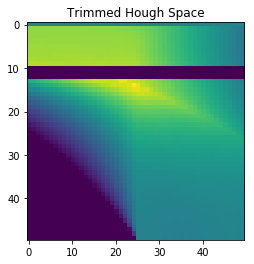

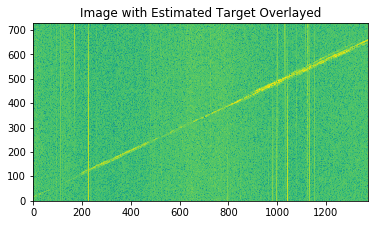

In [20]:
thm = houghm.copy()
i2k = np.abs(np.linspace(0, np.pi / 2, NTHETA) - CARRIER_THETA) < np.radians(2.5)
thm[i2k,:] = 0

plt.imshow(thm)
plt.title('Trimmed Hough Space')
plt.show()

[tlr, blr] = np.unravel_index(np.argmax(thm), thm.shape)
tl = np.linspace(0, np.pi / 2, NTHETA)[tlr]
bl = np.linspace(-img.shape[0], img.shape[0], NB)[blr]

xl = np.arange(0, img.shape[1], 1)
func = tbline(tl, img.shape[0] + bl)
yl = func(xl)

xl = xl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)
yl = yl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)

plt.imshow(img, origin='lower')
plt.plot(xl, yl, 'r')
plt.title('Image with Estimated Target Overlayed')
plt.show()

In [12]:
[tlr, blr] = np.unravel_index(np.argmax(houghm), houghm.shape)

tl = np.linspace(0, np.pi / 2, NTHETA)[tlr]
bl = np.linspace(-img.shape[0], img.shape[0], NB)[blr]

xl = np.arange(0, img.shape[1], 1)
func = tbline(tl, bl)
yl = func(xl)

xl = xl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)
yl = yl[np.logical_and(yl < img.shape[1], yl >= 0).nonzero()].astype(int)

# plt.imshow(np.flip(img, axis=1), origin='lower')
plt.imshow(img, origin='lower')
plt.plot(xl, yl, 'r')
plt.title('Image with Loudest Hough Line Overlayed')
plt.show()

array([], dtype=int64)

In [23]:
np.savetxt('thm.csv', thm, delimiter=',')

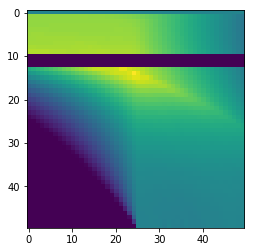

In [24]:
plt.imshow(thm)